# Homework 1 - Problem 3 - Beam Bending

# Imports

Notes on using cupy
https://docs.cupy.dev/en/stable/install.html

Cupy is a drop-in replacement for numpy, but it should be faster because it uses the GPU in my computer to run calculations.
So, we replace `import numpy as np` with `import cupy as np`.... if possible.

For this to work, you need an NVIDIA GPU and CUDA toolkit installed. 
I have a 1650Ti.
I can check the highest version of CUDA that can be installed by running `nvidia-smi`: the highest possible cuda toolkit version is showed in top right.
* This does NOT mean you already have the toolkit.
* So I install the toolkit (12.5) here:
* https://developer.nvidia.com/cuda-12-5-0-download-archive?target_os=Windows&target_arch=x86_64&target_version=11&target_type=exe_local


Thereafter, i can pip-install cupy (for the cuda 12 version) in my python `venv` as follows:
* `pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124`
    * this is neeeded to install pytorch to access the cuda toolkit
    * check for the specific version of pytorch you need here: https://pytorch.org/get-started/locally/ 
*  `pip install cupy-cuda12x` 


Since i'm running python in a venv, i need to make the CUDA Toolkit accessible.
* in powershell of the venv enter: `export CUDA_PATH="C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA"  # Replace with your actual path` 
* Go to my `.venv` -> `pyvenv.cfg` 
* include-system-site-packages = true

In [1]:
# imports for python things.
import os

# Imports for numpy OR cupy
import numpy as np
cupy_active = False

# import cupy as np  # this is a drop-in replacement for numpy, that uses the GPU instead of CPU for speed.
# cupy_active = True

# Imports for math
import matplotlib.pyplot as plt
from IPython.display import clear_output # Only for iPython

######################################## Import the functions written by Prof for class:
# Could do an "helper_imports.py" file package in the future for nice consolidation
from computekappa import computekappa
from crossMat import crossMat
from gradEb_hessEb import gradEb_hessEb
from gradEb import gradEb
from gradEs_hessEs import gradEs_hessEs
from gradEs import gradEs
from gradEt_hessEt import gradEt_hessEt_panetta
from hessEb import hessEb
from hessEs import hessEs
from rotateAxisAngle import rotateAxisAngle

# Additional helper functions for this homework
from getFb import getFb 
from getFs import getFs

quietRun = False

# Parameters for Homework 1 Problem 1

# Objective Functions

We define our equations of motion within the objective function, in order to compute f

## Objective Function - Implicit

In [2]:
def objfun_implicit(q_guess, q_old, u_old, dt, tol, maximum_iter,
           m, mMat,  # inertia
           EI, EA,   # elastic stiffness
           W, C,     # external force
           deltaL,
           free_index): # free_index indicates the DOFs that evolve under equations of motion
    """
    Returns the new position vector "q" of all points for all given inputs.
    Also returns a flag to indicate success or failure of the computation.
    This new position vector "q" is calculated with the implicit method via NewtonRaphson method convergence.

    Parameters:
    q_guess : float
        The guessed locality of the final solution, to ensure continuity and convergence, typically just the q_old point.
    q_old: float
        The previous q point from the last t timestamp.
    u_old: float
        The previous velocity u vector from the last t timestamp.
    dt: float
        The time between timestamps for simulation.
    tol: float
        The tolerance with which we deem the Newton Raphson solution is sufficiently converged
    maximum_iter: float
        Maximum number of iterations to try convergence, to make sure computer doesn't hang forever. 
    m, mMat: 
        mass matrices
    EI, EA:
        elastic stiffnesses: EA - stretching, EI - bending
    W, C:
        external forces - weight(W) and XXXX(C)
    deltaL:
        something
    free_index:
        free_index indicates the DOFs that evolve under equations of motion

    Returns:
    q_new : np.ndarray
       The new vector of positions at k+1
    flag: int
        1 if no error, -1 if fail to converge
    """

    q_new = q_guess.copy()

    # Newton-Raphson scheme
    iter_count = 0  # number of iterations
    error = tol * 10  # norm of function value (initialized to a value higher than tolerance)
    flag = 1  # Start with a 'good' simulation (flag=1 means no error)

    while error > tol:
        # Get elastic forces
        Fb, Jb = getFb(q_new, EI, deltaL)  # bending
        Fs, Js = getFs(q_new, EA, deltaL)  # stretching

        # Viscous force
        Fv = -C @ (q_new - q_old) / dt
        Jv = -C / dt

        ##################################################################
        # Equation of motion
        # Implicit
        f = m * (q_new - q_old) / dt**2 - m * u_old / dt - (Fb + Fs + W + Fv)
        # Explicit
        # f = 

        # Manipulate the Jacobians
        J = mMat / dt**2 - (Jb + Js + Jv)

        # We have to separate the "free" parts of f and J
        f_free = f[free_index]
        J_free = J[np.ix_(free_index, free_index)]

        # Newton's update
        # q_new = q_new - np.linalg.solve(J, f)
        # We have to only update the free DOFs
        dq_free = np.linalg.solve(J_free, f_free)
        q_new[free_index] = q_new[free_index] - dq_free

        # Get the norm
        # error = np.linalg.norm(f)
        # We have to calculate the errors based on free DOFs
        error = np.linalg.norm(f_free)

        # Update iteration number
        iter_count += 1
        if not quietRun:
            print(f'Iter={iter_count-1}, error={error:.6e}')

        if iter_count > maximum_iter:
            flag = -1  # return with an error signal
            return q_new, flag

    return q_new, flag

## Objective Function - Explicit

In [3]:
def objfun_explicit(q_guess, q_old, u_old, dt, tol, maximum_iter,
           m, mMat,  # inertia
           EI, EA,   # elastic stiffness
           W, C,     # external force
           deltaL,
           free_index): # free_index indicates the DOFs that evolve under equations of motion
    """
    Returns the new position vector "q" of all points for all given inputs.
    Also returns a flag to indicate success or failure of the computation.
    This new position vector "q" is calculated with the explicit method.
    There are redundant arguments in this function for ease of drop-in-and-replace of this function when called from Main().

    Parameters:
    q_guess : float
        The guessed locality of the final solution, to ensure continuity and convergence, typically just the q_old point.
    q_old: float
        The previous q point from the last t timestamp.
    u_old: float
        The previous velocity u vector from the last t timestamp.
    dt: float
        The time between timestamps for simulation.
    tol: float
        The tolerance with which we deem the Newton Raphson solution is sufficiently converged
    maximum_iter: float
        Maximum number of iterations to try convergence, to make sure computer doesn't hang forever. 
    m, mMat: 
        mass matrices
    EI, EA:
        elastic stiffnesses
    W, C:
        external forces
    deltaL:
        something
    free_index:
        free_index indicates the DOFs that evolve under equations of motion

    Returns:
    q_new : np.ndarray
       The new vector of positions at k+1
    flag: int
        1 if no error, -1 if fail to converge
    """
    q_new = q_guess.copy()

    # Newton-Raphson scheme
    iter_count = 0  # number of iterations
    error = tol * 10  # norm of function value (initialized to a value higher than tolerance)
    flag = 1  # Start with a 'good' simulation (flag=1 means no error)

    # while error > tol:
    # Get elastic forces
    Fb, Jb = getFb(q_old, EI, deltaL)  # bending
    Fs, Js = getFs(q_old, EA, deltaL)  # stretching

    # Viscous force
    Fv = -C @ u_old
    # Jv = -C / dt

    ##################################################################
    # Equation of motion
    # Implicit
    # f = m * (q_new - q_old) / dt**2 - m * u_old / dt - (Fb + Fs + W + Fv)
    # Explicit
    q_new = q_old + (dt**2 / m) * (Fb+Fs+W+Fv + m*(u_old/dt))

    return q_new, flag

# Simulation Code

In [4]:
min(0.75,1-0.75)

0.25

In [5]:
def runSimulation(
      nv,
      ndof,
      nodes,
      dt_setting,
      tol,
      maximum_iter,
      m,
      mMat,
      EI,
      EA,
      W,
      C,
      deltaL,
      free_index,
      plotStep,
      mode,
      midNode,
      RodLength,
      P_x_position,
      P_force,
      additional_cases_for_homework_string = ''
      ):
   # Time step
  dt = dt_setting  # from above, for this homework assignment

  # Initial conditions
  q0 = np.zeros(ndof)
  for c in range(nv):
      q0[2 * c] = nodes[c, 0]
      q0[2 * c + 1] = nodes[c, 1]

  q = q0.copy()
  u = (q - q0) / dt


  # Number of time steps
  Nsteps = round(totalTime / dt) + 1

  ctime = 0

  all_pos = np.zeros(Nsteps)
  all_v = np.zeros(Nsteps)
  midAngle = np.zeros(Nsteps)
  ymax = np.zeros(Nsteps) 
  ymaxNode = np.zeros(Nsteps)
 
  Euler_ymax_array = np.zeros(Nsteps)

  for timeStep in range(1, Nsteps):  # Python uses 0-based indexing, hence range starts at 1
      # print(timeStep)
      if not quietRun:
        print(f't={ctime:.6f}')

      if mode == 'implicit':
        q, error = objfun_implicit(q0, q0, u, dt, tol, maximum_iter, m, mMat, EI, EA, W, C, deltaL,
                          free_index) # This line is different from our previous exercise
      else:
        q, error = objfun_explicit(q0, q0, u, dt, tol, maximum_iter, m, mMat, EI, EA, W, C, deltaL,
                          free_index) # This line is different from our previous exercise

      if error < 0:
          print('Could not converge. Sorry')
          break  # Exit the loop if convergence fails

      u = (q - q0) / dt  # velocity
      ctime += dt  # current time

      # Update q0
      q0 = q
      

      ####################################
      if (not saveImage and timeStep % plotStep == 0
          ) or (saveImage and (timeStep*dt) in timestamps_for_report):
        
        if not quietRun:
          x1 = q[::2]  # Selects every second element starting from index 0
          x2 = q[1::2]  # Selects every second element starting from index 1
          h1 = plt.figure(1)
          plt.clf()  # Clear the current figure
          clear_output(wait=True)  # Clear the previous plot/output: Only for iPython
          plt.plot(x1, x2, 'ko-')  # 'ko-' indicates black color with circle markers and solid lines
          plt.title(mode + f' t={ctime:.6f}')  # Format the title with the current time
          plt.axis('equal')  # Set equal scaling
          plt.xlabel('x [m]')
          plt.ylabel('y [m]')
          # plt.show()  # Display the figure

          if not saveImage:
            plt.show()  # Display the figure
          else:  # because plt.show() messes up the savefig thing.
            filepath_fig_save = r'C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1'
            save_filename = problem_string + '_structureShape_t=' + str(timeStep*dt).replace('.', '_') + '.png'
            if mode == 'implicit':
              save_filename = problem_string + '_structureShape_implicit' + additional_cases_for_homework_string + '_t=' + str(timeStep*dt).replace('.', '_') + '.png'
            else:
              save_filename = problem_string + '_structureShape_explicit' + additional_cases_for_homework_string + '_t=' + str(timeStep*dt).replace('.', '_') + '.png'
            print(os.path.join(filepath_fig_save, save_filename))
            plt.savefig(os.path.join(filepath_fig_save, save_filename), 
                        # transparent=True, 
                        dpi=300,
                        )
      ####################################

      all_pos[timeStep] = q[2*midNode-1]  # Python uses 0-based indexing
      all_v[timeStep] = u[2*midNode-1]
      q_modified = q[1::2]  # every odd number index of q
      ymaxNode[timeStep] = np.argmin(q_modified) + 1
      
      ymax[timeStep] = q_modified[int(ymaxNode[timeStep])-1]

      # Angle at the center
      vec1 = np.array([q[2*midNode-2], q[2*midNode-1], 0]) - np.array([q[2*midNode-4], q[2*midNode-3], 0])
      vec2 = np.array([q[2*midNode], q[2*midNode+1], 0]) - np.array([q[2*midNode-2], q[2*midNode-1], 0])
      midAngle[timeStep] = np.degrees(np.arctan2(np.linalg.norm(np.cross(vec1, vec2)), np.dot(vec1, vec2)))

      ####################################
      ### Now calculate Euler Method Prediction
      # l = length of bar = RodLength
      # d = 0.75 = P_x_position
      # L = l = length of bar = RodLength

      c = min(P_x_position, RodLength-P_x_position)
      c = 0.25  # min of 0.75 and 1-0.75=0.25
      euler_ymax = (-P_force * c * (RodLength**2 - c**2)**1.5) / (9 * np.sqrt(3) * EI * RodLength)

      Euler_ymax_array[timeStep] = euler_ymax




  t = np.linspace(0, totalTime, Nsteps)
  if not quietRun:
    # # Plot
    # plt.figure(2)
    # # t = np.linspace(0, totalTime, Nsteps)
    # plt.plot(t, all_pos)
    # plt.xlabel('Time, t [s]')
    # plt.ylabel('Displacement, $\\delta$ [m]')
    # # plt.savefig('fallingBeam.png')
    # if mode == 'implicit':
    #     save_filename = problem_string + 'fallingBeam_implicit' + additional_cases_for_homework_string + '.png'
    # else:
    #     save_filename = problem_string + 'fallingBeam_explicit' + additional_cases_for_homework_string + '.png'
    # filepath_fig_save = r'C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1'
    # print(os.path.join(filepath_fig_save, save_filename))
    # plt.savefig(os.path.join(filepath_fig_save, save_filename), 
    #             # transparent=True, 
    #             dpi=300,
    #             )

    # plt.figure(3)
    # plt.plot(t, all_v)
    # plt.xlabel('Time, t [s]')
    # plt.ylabel('Velocity, v [m/s]')
    # # plt.savefig('fallingBeam_velocity.png')
    # if mode == 'implicit':
    #     save_filename = problem_string + 'fallingBeam_velocity_implicit' + additional_cases_for_homework_string + '.png'
    # else:
    #     save_filename = problem_string + 'fallingBeam_velocity_explicit' + additional_cases_for_homework_string + '.png'
    # filepath_fig_save = r'C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1'
    # print(os.path.join(filepath_fig_save, save_filename))
    # plt.savefig(os.path.join(filepath_fig_save, save_filename), 
    #             # transparent=True, 
    #             dpi=300,
    #             )

    # plt.figure(4)
    # plt.plot(t, midAngle, 'r')
    # plt.xlabel('Time, t [s]')
    # plt.ylabel('Angle, $\\alpha$ [deg]')
    # # plt.savefig('fallingBeam_angle.png')
    # if mode == 'implicit':
    #     save_filename = problem_string + 'fallingBeam_angle_implicit' + additional_cases_for_homework_string + '.png'
    # else:
    #     save_filename = problem_string + 'fallingBeam_angle_explicit' + additional_cases_for_homework_string + '.png'
    # filepath_fig_save = r'C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1'
    # print(os.path.join(filepath_fig_save, save_filename))
    # plt.savefig(os.path.join(filepath_fig_save, save_filename), 
    #             # transparent=True, 
    #             dpi=300,
    #             )

    plt.figure(5)
    plt.plot(t, ymax, 'r', label='simulation')
    plt.plot(t, Euler_ymax_array, 'b', label='EulerBernouli')
    plt.legend()
    plt.xlabel('Time, t [s]')
    plt.ylabel('Ymax displacement, $Ymax$ [m]')
    # plt.savefig('fallingBeam_angle.png')
    if mode == 'implicit':
        save_filename = problem_string + 'elasticBeam_ymax_implicit' + additional_cases_for_homework_string + '.png'
    else:
        save_filename = problem_string + 'elasticBeam_ymax_explicit' + additional_cases_for_homework_string + '.png'
    filepath_fig_save = r'C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1'
    print(os.path.join(filepath_fig_save, save_filename))
    plt.savefig(os.path.join(filepath_fig_save, save_filename), 
                # transparent=True, 
                dpi=300,
                )

    plt.show()


    

  return t, all_pos, all_v, midAngle, ymax, ymaxNode, Euler_ymax_array

# Simulation Wrapper
Includes setting up constants for each simulation via arguments of nv, dt

In [6]:
def simulation_case(
      plotStep, 
      mode,
      dt_setting,
      additional_cases_for_homework_string,
      P_force,
      nv,
      ):
  
  ######################### First we set up constants for the case

#   P = 2000  # [N]

  # number of vertices
  # nv = 21 # Odd vs even number should show different behavior

  # Inputs (SI units)
  ndof = 2*nv

  # Rod Length
  RodLength = 1  # [m]

  # Discrete length
  deltaL = RodLength / (nv - 1)  # [m]

  # Radius of spheres - General Formulation
  midNode = int((nv + 1) / 2)

  # if cupy_active:
  #     # Radius of spheres - Homework Assignment 1
  #     R = np.array([0.005, 0.025, 0.005]) # --> this is calculated from general for nv = 3
  # else:

  # Radius, outer
  Ro = 0.013  # [m]

  # Radius, inner
  Ri = 0.011  # [m]

  # R = np.zeros(nv)  # Vector of size N - Radius of N nodes
  # R[:] = deltaL / 10 # Course note uses deltaL/10
  # R[midNode -1 ] = 0.025
  # # R[midNode -1 ] = 0.005  # For deliverable 3.
  # # R units are [m]


  # # Densities
  # rho_metal = 7000  # [kg / m^3]
  # rho_gl = 1000  # [kg / m^3]
  rho = 2700  # [kg / m^3]

  # # Cross-sectional radius of rod
  # r0 = 1e-3  # [m]

  # Young's modulus
  Y = 70 * 1e9  # [Pa]

  # # Viscosity
  # visc = 1000.0  # [Pa-s]

  # Maximum number of iterations in Newton Solver
  maximum_iter = 100

  # Utility quantities
  ne = nv - 1
  EI = (Y * np.pi * (Ro**4 - Ri**4)) / 4  # Bending Stiffness
  EA = (Y * np.pi * (Ro**2 - Ri**2))      # Stretching stiffness

  # Tolerance on force function
  tol = EI / RodLength**2 * 1e-3  # small enough force that can be neglected

  # Geometry of the rod
  nodes = np.zeros((nv, 2))
  for c in range(nv):
      nodes[c, 0] = c * RodLength / ne


  # Compute Mass
  # m = np.zeros(ndof)
  # for k in range(nv):
  #     m[2*k] = 4 / 3 * np.pi * R[k]**3 * rho_metal # Mass for x_k
  #     m[2*k+1] = m[2*k] # Mass for y_k

  m = (np.ones(ndof) * np.pi * (Ro**2 - Ri**2) * RodLength * rho) / (nv-1)

  mMat = np.diag(m)  # Convert into a diagonal matrix

  # Gravity
  W = np.zeros(ndof)
  g = np.array([0, -9.8])  # m/s^2 - gravity
  for k in range(nv):
    # Just weight by itself:
    W[2*k]   = m[2*k] * g[0] # Weight for x_k
    W[2*k+1] = m[2*k] * g[1] # Weight for y_k
  

  ########## ADD P
  # We are doing a trick to add "P" on a specific node... we're going to add it to the weight term artificially.
  # First, find the closest node to P (@ x = 0.75m)
  # array of node positions
  node_positions = np.arange(0, RodLength, deltaL)
  
  # Find the index of the node closest to the target x-value
  P_x_position = 0.75
  closest_index_to_P = np.argmin(np.abs(node_positions - P_x_position))
  W[closest_index_to_P * 2 + 1] = W[closest_index_to_P * 2 + 1] - P_force  # Add P as a force directly on that node --> DOWNWARDS

  # import time
  # time.sleep(1000)
  # Viscous damping matrix, C
  C = np.zeros((ndof, ndof))  # no viscous drag
  # for k in range(nv):
  #   C[2*k,2*k]   = 6 * np.pi * visc * R[k]
  #   C[2*k+1, 2*k+1]   = 6 * np.pi * visc * R[k]


  # FIGURE OUT FREE AND FIXED DOFs
  all_DOFs = np.arange(ndof)
  # 0: 0th index = 1st node X dir
  # 1: 1st index = 1st node Y dir
  # ndof: ndofth index = last node Y dir
  fixed_index = np.array([0, 1, ndof-1]) 
  # fixed_index = np.array([])  # All are free.

  # Get the difference of two sets using np.setdiff1d
  free_index = np.setdiff1d(all_DOFs, fixed_index)


  # NOW WE RUN THE MAIN CODE:
  t, all_pos, all_v, midAngle, ymax, ymaxNode, Euler_ymax_array = runSimulation(
      nv,
      ndof,
      nodes,
      dt_setting,
      tol,
      maximum_iter,
      m,
      mMat,
      EI,
      EA,
      W,
      C,
      deltaL,
      free_index,
      plotStep,
      mode,
      midNode,
      RodLength,
      P_x_position,
      P_force,
      additional_cases_for_homework_string,
      )
  return t, all_pos, all_v, midAngle, ymax, ymaxNode, Euler_ymax_array

# Actually run the code

## Case for nominal

In [7]:
quietRun = False
# Time Stamps for snapshot:
# timestamps_for_report = [0, 0.01, 0.05, 0.10, 1.0, 10.0]  # Make sure these timestamps are within resolution of dt_setting!!!
# timestamps_for_report = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
timestamps_for_report = [1]

# Indicate whether images should be saved
# saveImage = False
saveImage = True

# Total simulation time (it exits after t=totalTime)
totalTime = 1

problem_string = 'hw1_p3'
mode = 'implicit'
plotStep = 2

C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1\hw1_p3_structureShape_implicitpart1_2000_t=1_0.png
C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1\hw1_p3elasticBeam_ymax_implicitpart1_2000.png


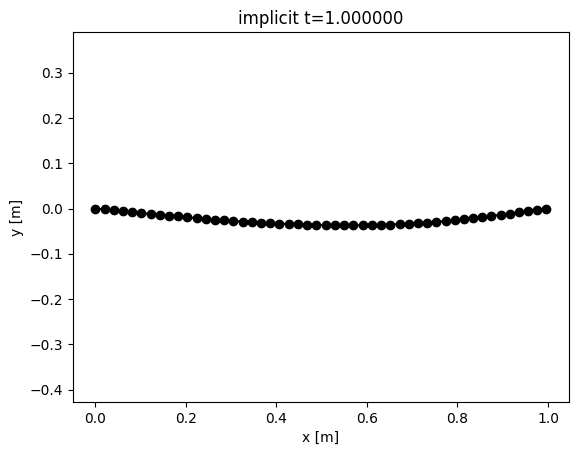

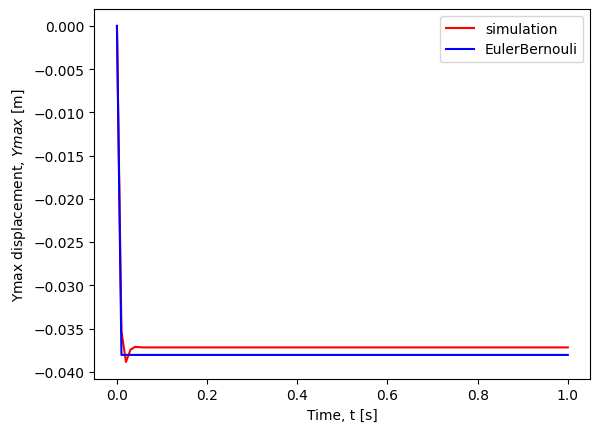

-0.0371748195100227
-0.038044915643450306


In [8]:
additional_cases_for_homework_string = 'part1_2000'
dt_setting = 1e-2
nv = 50
P_force = 2000 # [N]
# P_force = 2
    
t, all_pos, all_v, midAngle, ymax, ymaxNode, Euler_ymax_array = simulation_case(
    plotStep, 
    mode,
    dt_setting,
    additional_cases_for_homework_string,
    P_force,
    nv,
    )
    

print(ymax[-1])
print(Euler_ymax_array[-1])

C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1\hw1_p3_structureShape_implicitpart2_20000_t=1_0.png
C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1\hw1_p3elasticBeam_ymax_implicitpart2_20000.png


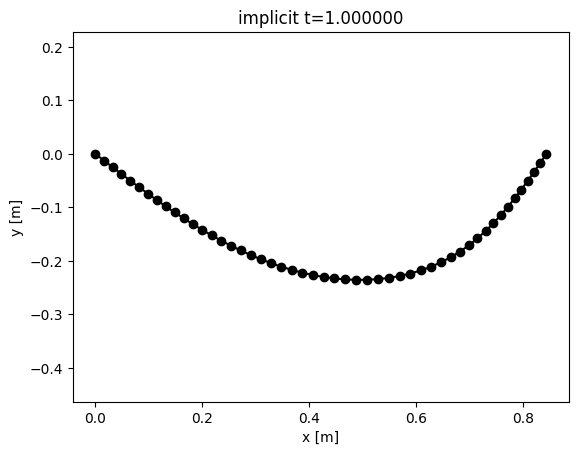

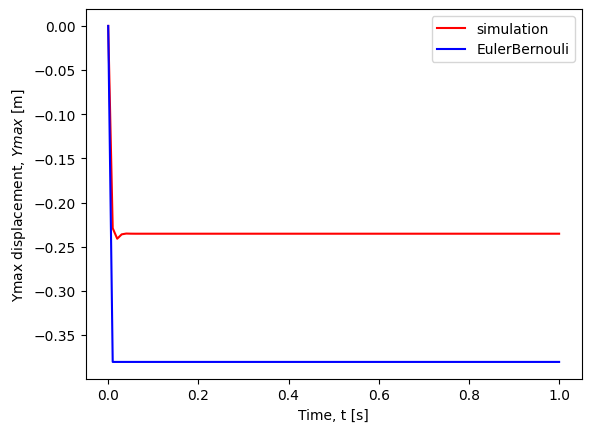

-0.23527908997604974
-0.3804491564345031


In [9]:
additional_cases_for_homework_string = 'part2_20000'
dt_setting = 1e-2
nv = 50
P_force = 20000 # [N]
    
t, all_pos, all_v, midAngle, ymax, ymaxNode, Euler_ymax_array = simulation_case(
    plotStep, 
    mode,
    dt_setting,
    additional_cases_for_homework_string,
    P_force,
    nv=nv,
    )
    

print(ymax[-1])
print(Euler_ymax_array[-1])

## Cases to run for deliverable #3

Completed number of nodes: 5000
Completed number of nodes: 10000
Completed number of nodes: 15000
Completed number of nodes: 20000
[-0.0889938  -0.1574856  -0.20406978 -0.23527909]
C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1\hw1_p3P_vs_Ymax.png


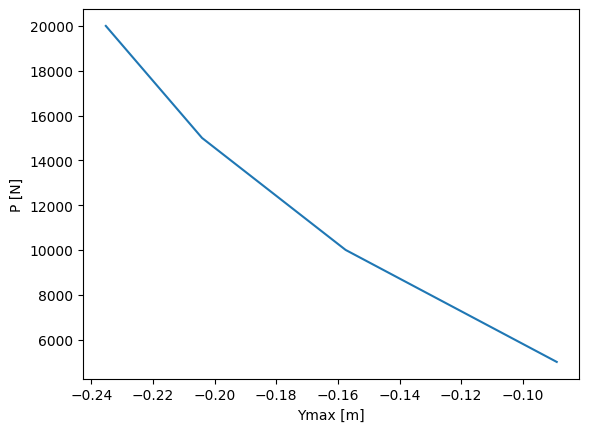

In [10]:
################################################
quietRun = True
saveImage = True  # this is for the regular plots that are saved within each case. We turn that off.
# Loop through number of nodes:
# number_of_nodes = [17, 19, 21, 23]  # 'nv'
P_to_loop = [5000, 10000, 15000, 20000]  # 'nv'
dt_setting = 1e-2
# time_step_sizes = [1e-1, 5e-1, 1e-2, 1.5e-2, 2e-2]  # dt_setting


additional_cases_for_homework_string = 'part2_PvsYmax'
dt_setting = 1e-2
nv = 50

ymax_array = np.empty(0)

for P_force in P_to_loop:
    t, all_pos, all_v, midAngle, ymax, ymaxNode, Euler_ymax_array = simulation_case(
        plotStep, 
        mode,
        dt_setting,
        additional_cases_for_homework_string,
        P_force,
        nv=nv,
        )

    # print(ymax)

    ymax_array = np.append(ymax_array, ymax[-1])
    print('Completed number of nodes: ' + str(P_force))

print(ymax_array)

plt.figure(5)
plt.plot(ymax_array, P_to_loop)
plt.xlabel('Ymax [m]')
plt.ylabel('P [N]')
# plt.savefig('fallingBeam_velocity.png')

save_filename = problem_string + 'P_vs_Ymax.png'
filepath_fig_save = r'C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1'
print(os.path.join(filepath_fig_save, save_filename))
plt.savefig(os.path.join(filepath_fig_save, save_filename), 
            # transparent=True, 
            dpi=300,
            )


In [11]:
# ################################################
# quietRun = True
# saveImage = False  # this is for the regular plots that are saved within each case. We turn that off.
# # Loop through time step size
# # number_of_nodes = [17, 19, 21, 23]  # 'nv'
# nv = 21
# dt_step_sizes = [1e-1, 5e-1, 1e-2, 1.5e-2, 2e-2]  # dt_setting
# dt_step_sizes = [5e-2, 2e-2, 1e-2, 5e-3]  # dt_setting
# # dt_setting = 1e-2


# v_terminal_step_sizes = np.empty(0)

# for dt_setting in dt_step_sizes:

#     if dt_setting == 1e-2:
#         v_terminal_step_sizes = np.append(v_terminal_step_sizes, v_terminal_nominal)
#     else:
#         additional_cases_for_homework_string = 'node_' + str(nv)
#         t, all_pos, all_v, midAngle = simulation_case(
#             plotStep, 
#             mode,
#             dt_setting,
#             additional_cases_for_homework_string,
#             P_force,
#             nv=nv,  
#             )

#         v_terminal_step_sizes = np.append(v_terminal_step_sizes, all_v[-1])
    
#     print('Completed dt setting: ' + str(dt_setting))
    

# plt.figure(6)
# plt.plot(dt_step_sizes, v_terminal_step_sizes)
# plt.xlabel('StepSizes, dt [s]')
# plt.ylabel('Terminal Velocity, v [m/s]')
# # plt.savefig('fallingBeam_velocity.png')

# save_filename = problem_string + 'terminalVelocity_vs_stepSizes.png'
# filepath_fig_save = r'C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1'
# print(os.path.join(filepath_fig_save, save_filename))
# plt.savefig(os.path.join(filepath_fig_save, save_filename), 
#             # transparent=True, 
#             dpi=300,
#             )

In [12]:
plt.figure(6)
plt.plot(dt_step_sizes[1:], v_terminal_step_sizes[1:])
plt.xlabel('StepSizes, dt [s]')
plt.ylabel('Terminal Velocity, v [m/s]')
# plt.savefig('fallingBeam_velocity.png')

save_filename = problem_string + 'terminalVelocity_vs_stepSizes.png'
filepath_fig_save = r'C:\Users\limhe\OneDrive\Documents\0_Classes UCLA\0_MAE 263F_Mechanics of Flexible Structures and Soft Robots\HW1'
print(os.path.join(filepath_fig_save, save_filename))
plt.savefig(os.path.join(filepath_fig_save, save_filename), 
            # transparent=True, 
            dpi=300,
            )

NameError: name 'dt_step_sizes' is not defined

<Figure size 640x480 with 0 Axes>